### Cab-Driver Agent

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import adam_v2

# for plotting graphs
import matplotlib.pyplot as plt

#### Defining Time Matrix

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("/content/drive/MyDrive/PGD_IIITB_Student/Cab_Driver_Assignment/TM.npy")

#### Tracking the state-action pairs for checking convergence


In [ ]:
%cd /content/drive/My\ Drive/PGD_IIITB_Student/Cab_Driver_Assignment

In [7]:
import Env

In [8]:
from Env import CabDriver

In [9]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [10]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01       
        self.epsilon_max = 1
        self.epsilon_decay = 0.9991
        self.epsilon_min = 0.01
        self.epsilon = 1
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse',optimizer=adam_v2.Adam(learning_rate=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment    
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # Give a random action only amongst possible action
            return random.sample(possible_actions_index,1)[0]
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]   
        
        
        
        
        


    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                update_output[i] = next_state
                
                # Write your code from here
                # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
                # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)  
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                
                
        # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

In [11]:
Episodes = 3500

### DQN block

In [ ]:
agent = DQNAgent(36,21)
rewards_per_episode, episodes = [], []


for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    env = CabDriver()
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    arch1 = env.state_encod_arch1(state)
    action = agent.get_action(arch1,env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        loop+= 1

    rewards_per_episode.append(score)   
    episodes.append(episode)
        
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs

        # save model weights
        agent.save(name="model_weights.h5")

Streaming output truncated to the last 5000 lines.
episode 874, reward -64.0, memory_length 2000, epsilon 0.4548195246816094, time 720.0, rides 121
Initial State is  [0, 8, 0]
episode 875, reward 255.0, memory_length 2000, epsilon 0.45441018710939596, time 729.0, rides 117
Initial State is  [2, 13, 2]
episode 876, reward 260.0, memory_length 2000, epsilon 0.4540012179409975, time 726.0, rides 130
Initial State is  [0, 14, 2]
episode 877, reward 159.0, memory_length 2000, epsilon 0.45359261684485064, time 733.0, rides 133
Initial State is  [1, 5, 1]
episode 878, reward 225.0, memory_length 2000, epsilon 0.45318438348969026, time 729.0, rides 109
Initial State is  [2, 12, 3]
episode 879, reward -18.0, memory_length 2000, epsilon 0.4527765175445495, time 729.0, rides 129
Initial State is  [0, 14, 5]
episode 880, reward 249.0, memory_length 2000, epsilon 0.4523690186787594, time 726.0, rides 119
Initial State is  [3, 21, 4]
episode 881, reward 201.0, memory_length 2000, epsilon 0.451961886

In [18]:
agent.memory

deque([(array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        6,
        36.0,
        array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        False),
       (array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        9,
        28.0,
        array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        False),
       (array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 

### Tracking Convergence

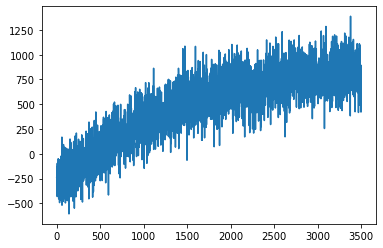

In [13]:
plt.plot(episodes,rewards_per_episode)

Due to compute restraint we have to use 3500 episodes to train.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [14]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

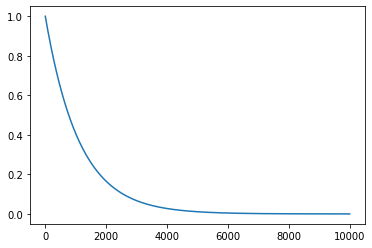

In [15]:
plt.plot(time, epsilon)
plt.show()